In [1]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cpu].
CPU times: user 1.87 s, sys: 486 ms, total: 2.35 s
Wall time: 1.37 s


In [2]:
%%time

dataset = create_dataset('criteo', sample_num=100000, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 3.94 s, sys: 261 ms, total: 4.21 s
Wall time: 4.2 s


读 100K 数据的情况下，特征为 241895 维。

In [3]:
class LogisticRegression(nn.Module):
    
    def __init__(self, field_dims):
        super(LogisticRegression, self).__init__()
        
        self.bias = nn.Parameter(torch.zeros((1, )))
        self.embed = FeaturesEmbedding(field_dims, 1)

    def forward(self, x):
        # x shape: (batch_size, num_fields)
        output = self.embed(x).sum(dim=1) + self.bias
        output = torch.sigmoid(output)
        return output


 60%|██████    | 361/600 [00:29<00:19, 12.34it/s]


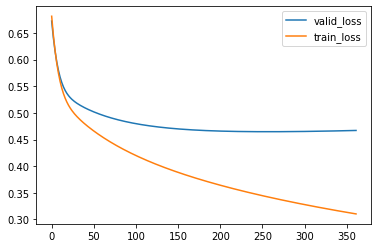

train_loss: 0.34051 | train_metric: 0.91166
valid_loss: 0.46473 | valid_metric: 0.75587
test_loss:  0.44877 | test_auc:  0.76514
CPU times: user 1min 32s, sys: 8.62 s, total: 1min 40s
Wall time: 29.6 s


In [4]:
%%time

LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

lr = LogisticRegression(field_dims).to(device)
optimizer = optim.Adam(lr.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(lr, optimizer, criterion, BATCH_SIZE)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))
